In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from mpl_toolkits.mplot3d import Axes3D

### constant delta on the grid transform

In [3]:
side = 50
spacing = 5
n_cell = int(side//spacing)

x = np.arange(0,side,spacing)
y = np.arange(0,side,spacing)
z = np.arange(0,side,spacing)

X, Y, Z = np.meshgrid(x, y, z)

vol = side**3
print(spacing)
print(side)
print(vol)

5
50
125000


Text(0.5, 0.92, 'congifuration space')

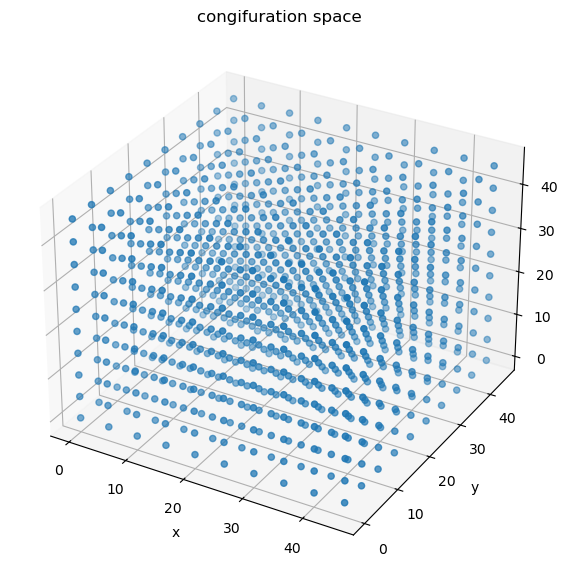

In [4]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('congifuration space')

In [5]:
grid = np.array([X,Y,Z])
print(grid.shape)

(3, 10, 10, 10)


In [6]:
kx = np.fft.fftfreq(n_cell, spacing)*np.pi*2
ky = np.fft.fftfreq(n_cell, spacing)*np.pi*2
kz = np.fft.rfftfreq(n_cell, spacing)*np.pi*2

kx = np.fft.fftshift(kx)
ky = np.fft.fftshift(ky)


print(kx.shape, ky.shape, kz.shape)

kxs, kys, kzs = np.meshgrid(kx,ky,kz, indexing='ij')

print(kxs.shape, kys.shape, kzs.shape)

(10,) (10,) (6,)
(10, 10, 6) (10, 10, 6) (10, 10, 6)


Text(0.5, 0.92, 'fourier space')

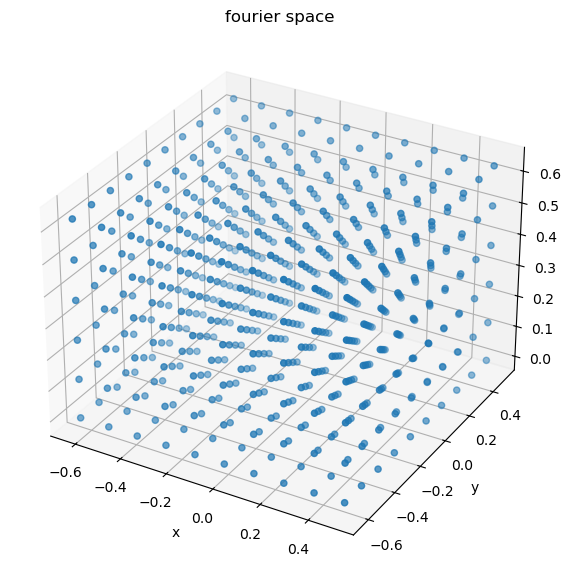

In [7]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kxs,kys,kzs)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('fourier space')

(10, 10, 10)


Text(0.5, 0.92, 'delta in config space')

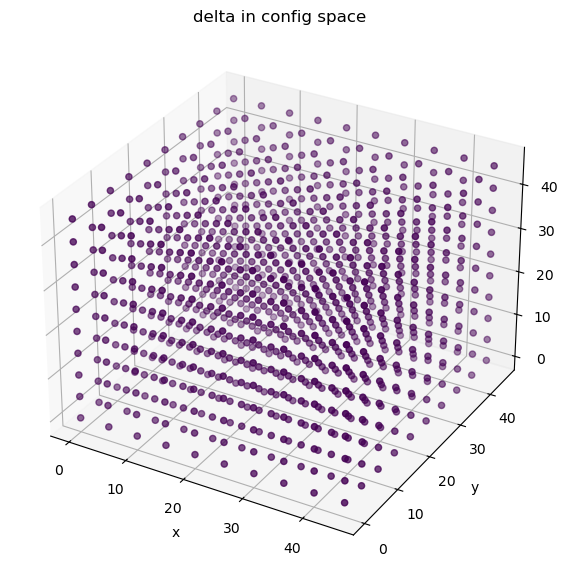

In [8]:
## define a constant overdensity field on the grid
delta = np.full_like(X, 3)
print(delta.shape)

fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c=delta)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('delta in config space')

(10, 10, 10)
(10, 10, 6)


/Users/edoardo/miniconda3/envs/acc-env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:4458: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


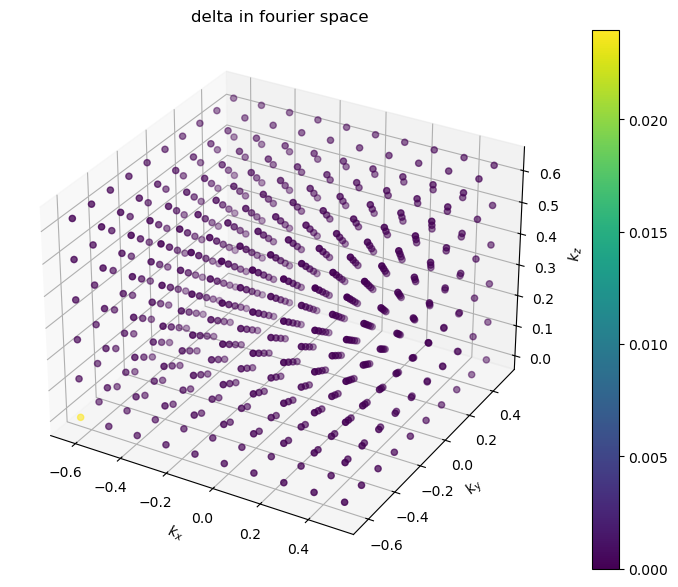

In [9]:
delta_transform = np.fft.rfftn(delta)/vol
print(delta.shape)
print(delta_transform.shape)

fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
scp = ax.scatter(kxs,kys,kzs, c=delta_transform)
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$k_z$')
ax.set_title('delta in fourier space')

plt.colorbar(scp)

Remember that $\mathcal{F}[const]=\delta_D (0)$: $\delta(k)$ is zero everywhere except in the origin

In [10]:
## computing P(k)=delta delta
Pk = vol * np.array(np.abs(delta_transform))**2
print(Pk.shape)

(10, 10, 6)


In [11]:
'''fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
scp = ax.scatter(kxs,kys,kzs, c=Pk)
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$k_z$')
ax.set_title('Power Spectrum')
plt.colorbar(scp)'''

"fig = plt.figure(figsize=(11,7))\nax = fig.add_subplot(111, projection='3d')\nscp = ax.scatter(kxs,kys,kzs, c=Pk)\nax.set_xlabel(r'$k_x$')\nax.set_ylabel(r'$k_y$')\nax.set_zlabel(r'$k_z$')\nax.set_title('Power Spectrum')\nplt.colorbar(scp)"

In [12]:
## computing norm of the wavevectors

k_norm = np.sqrt(kxs**2+kys**2+kzs**2)
print(k_norm.shape)


(10, 10, 6)


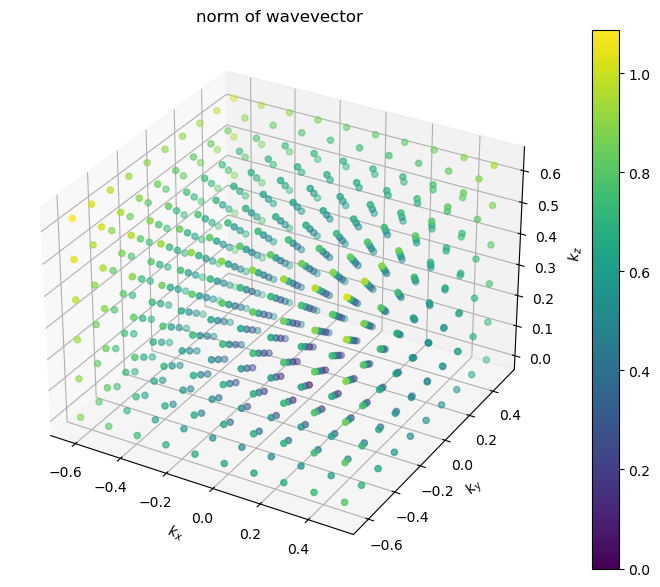

In [13]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
scp = ax.scatter(kxs,kys,kzs, c=k_norm)
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$k_z$')
ax.set_title('norm of wavevector')
plt.colorbar(scp)

Now I need to bin P(k): consider bins with the same abs(k) within a certain range and average P(k) in these bins

In [14]:
kN = 2 * np.pi / spacing              # max frequency based on spacing
kF = 2 * np.pi / side               # min frequency based on side length

print('fundamental freq = ', kF)
print('Nyquist freq = ',  kN)

# Define the edges for the wavevector bins
k_bin_edges = np.arange(kF, kN, kF)    # Edges of the bins in abs(k)

print(k_bin_edges)

fundamental freq =  0.12566370614359174
Nyquist freq =  1.2566370614359172
[0.12566371 0.25132741 0.37699112 0.50265482 0.62831853 0.75398224
 0.87964594 1.00530965 1.13097336]


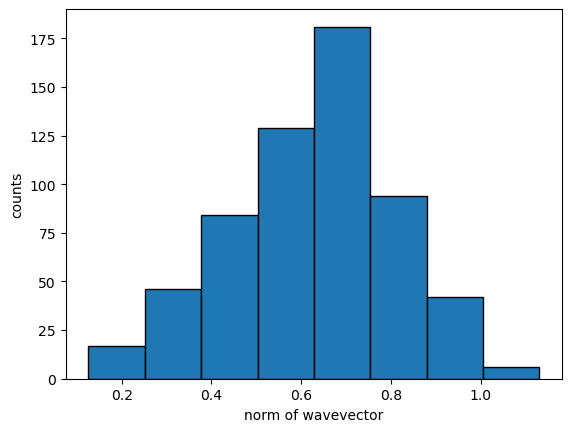

In [15]:
# Plot the histogram
plt.hist(k_norm.flatten(), k_bin_edges, edgecolor='black')
plt.xlabel('norm of wavevector')
plt.ylabel('counts')
plt.show()

Compute the binned Power spectrum averaging on circles in k-space, that is on cells where the norm of k is within a certain range

In [16]:
# Initialize arrays to store the bin values and the mean values of k_norm and Pk within each bin
k_bin = (k_bin_edges[1:]+k_bin_edges[0:-1])/2
print(k_bin)
pk_meas = np.zeros(k_bin.shape)

# Loop through each bin edge
for i in range(len(k_bin)-1):
    # Find indices where the values of k_norm fall within the range defined by the bin edges
    indices_in_bin = np.where((k_norm.flatten() >= k_bin_edges[i]) & (k_norm.flatten() < k_bin_edges[i + 1]))[0]
    
    # Calculate the mean value of Pk within the bin
    pk_meas[i] = np.mean(Pk.flatten()[indices_in_bin])


[0.18849556 0.31415927 0.43982297 0.56548668 0.69115038 0.81681409
 0.9424778  1.0681415 ]


Text(0, 0.5, '$P(k)$')

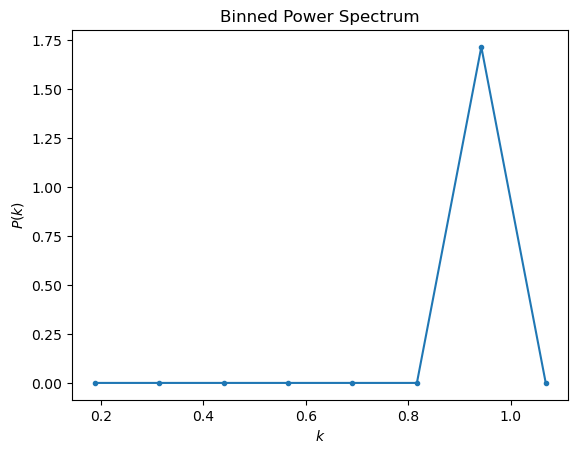

In [17]:
plt.plot(k_bin,pk_meas, marker = '.')
plt.title('Binned Power Spectrum')
plt.xlabel('$k$')
plt.ylabel('$P(k)$')


### digitize 
This can also be achieved using a np histogram object and the np.digitise function

In [18]:
k_hist, k_bin_edges = np.histogram(k_norm, bins=k_bin_edges)

In [19]:
k_bin_v2 = (k_bin_edges[1:]+k_bin_edges[0:-1])/2
pk_meas_v2 = np.zeros(len(k_bin_edges) - 1)

# Digitize the values of k_norm to determine the bin indices
bin_indices = np.digitize(k_norm.flatten(), k_bin_edges) - 1  # Subtract 1 to match 0-based indexing

# Iterate over each bin
for i in range(len(k_bin_edges) - 1):
    # Find indices where the bin index matches the current bin
    indices_in_bin = np.where(bin_indices == i)[0]

    # Calculate the mean value of k_norm within the bin
    if len(indices_in_bin) > 0:
        #k_bin_v2[i] = np.mean(k_norm.flatten()[indices_in_bin])

        # Calculate the mean value of Pk within the bin
        if k_hist[i] != 0:  # avoid division by zero
            pk_meas_v2[i] /= k_hist[i]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.81998371e-34 0.00000000e+00 1.71428571e+00 0.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0.]


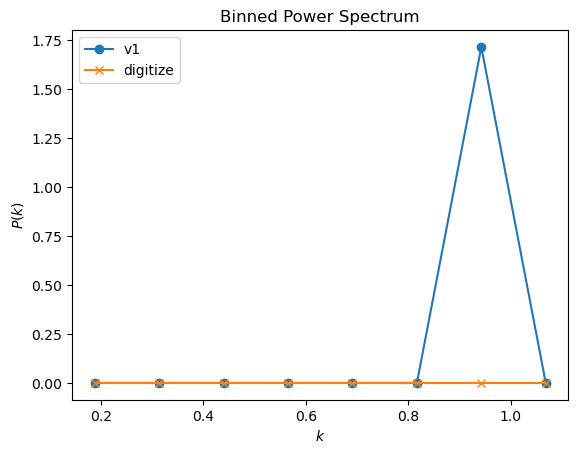

In [20]:
print(pk_meas)
print(pk_meas_v2)
plt.plot(k_bin,pk_meas, marker = 'o', label='v1')
plt.plot(k_bin_v2,pk_meas_v2, marker = 'x', label='digitize')
plt.title('Binned Power Spectrum')
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.legend()

In [21]:
import sys
import os
sys.path.append(os.path.relpath('/Users/edoardo/AstroCosmoComputational/Students/MaraglianoEdo/'))  
from pyACC.clustering.clustering_measure import get_power_spectrum

## clustering module test

In [22]:
k_bin_v3, pk_meas_v3 = get_power_spectrum(delta, side, spacing)


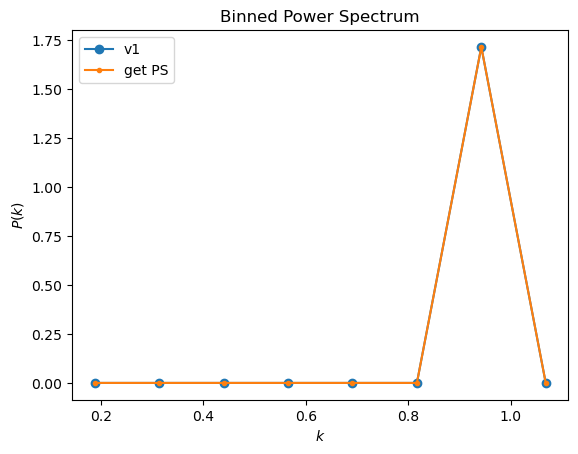

In [23]:
plt.plot(k_bin,pk_meas, marker = 'o', label='v1')
plt.plot(k_bin_v3,pk_meas_v3, marker = '.', label='get PS')
plt.title('Binned Power Spectrum')
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.legend()